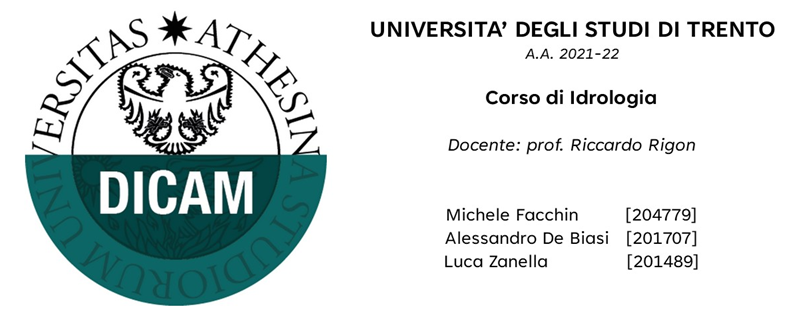

In [1]:
import os
from IPython.display import Image
whetgeo_project_path= os.path.dirname(os.getcwd())
Image(whetgeo_project_path+'\\Intestazione notebook.png')

# **Infiltrazione attraverso un terreno con due strati e deflusso dunniano**

### **Finalità** 

Analizzare l'infiltrazione attraverso un terreno composto da 2 strati (come in figura) sottoposto a deflusso dunniano dovuto a precipitazione con intensità sinusoidale.

Si ottengono e si rappresentano:

- Profilo verticale di GRADO DI SATURAZIONE
- Andamento nel tempo della SUZIONE a diverse profondità
- Andamento nel tempo del CONTENUTO D'ACQUA a diverse profondità
- Andamento nel tempo del FLUSSO D'ACQUA in superficie
- Andamento nel tempo del FLUSSO D'ACQUA sul fondo
- Andamento nel tempo del FLUSSO D'ACQUA cumulato in superficie
- Andamento nel tempo del FLUSSO D'ACQUA cumulato sul fondo

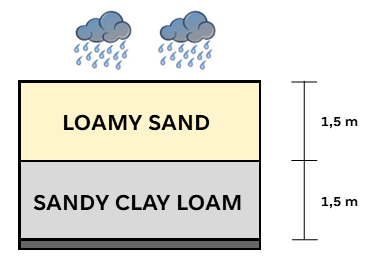

In [2]:
Image(whetgeo_project_path+'\\stratigrafia3.png')

### **Condizioni iniziali**

- Terreno saturo
- Distribuzione di pressione idrostatica


### **Condizioni al contorno**

- Fondo impermeabile
- Pressione d'acqua costante sul fondo


### **Modello utilizzato**

Le proprietà idrauliche del terreno sono definite dal modello di Van Genuchten e Brooks Corey.

In [3]:
import os
import pandas as pd

from geoframepy.whetgeo1d import grid_creator
from geoframepy.whetgeo1d import grid_to_netcdf

import warnings
warnings.filterwarnings('ignore')


project_path = os.path.dirname(os.getcwd())


grid_input_file_name = project_path + "/data/Grid_input/E3_grid_bc.csv"

ic_input_file_name = project_path + "/data/Grid_input/E3_ic.csv"

parameter_input_file_name = project_path + "/data/Grid_input/Richards_BC.csv"

dictionary_input_file_name = project_path + "/data/Grid_input/dictionary.csv"

grid_type = 'classical'

dz_min = -9999 # not required for grid_type = 'classical'

dz_max = -9999 # not required for grid_type = 'classical'

b = -9999      # not required for grid_type = 'classical'

psi_interp_model = "linear"

T_interp_model = "linear"

water_ponding_0 = -3.0

T_water_ponding_0 = 273.15

output_file_name =  project_path + "/data/Grid_NetCDF/E3_grid_bc.nc"

output_title = '''Computational grid for Terreno 3.
                  '''
output_summary = '''
Loamy sand
Sandy clay

Type,eta,K,equationStateID,parameterID
L,0.0,50,1,2
L,-1.5,50,1,10
L,-3.0,0,nan,nan

eta,Psi0,T0
-0.0,-3.0,273.15
-3.0,0.0,273.15

'''

output_date = ''

output_institution = 'GEOframe'



In [4]:
data_grid = pd.read_csv(grid_input_file_name)
# print('Grid')
# print(data_grid)
# print()

data_ic = pd.read_csv(ic_input_file_name)
# print('IC')
# print(data_ic)
# print()

data_parameter = pd.read_csv(parameter_input_file_name, comment='#')
# print('Parameter')
# print(data_parameter)
# print()

data_dictionary = pd.read_csv(dictionary_input_file_name)

[KMAX, eta, eta_dual, space_delta, z, z_dual, control_volume] = grid_creator.grid1D(data_grid, dz_min, b, dz_max, grid_type, shallow_water=True)

[psi_0, T_0] = grid_creator.set_initial_condition(data_ic, eta, psi_interp_model, T_interp_model, water_ponding_0=water_ponding_0, T_water_ponding_0=T_water_ponding_0, shallow_water=True)

control_volume_index = grid_creator.calibration_point_index(data_grid, eta)

[equation_state_ID, parameter_ID, theta_s, theta_r, par_1, par_2, par_3, par_4,
par_5, alpha_ss, beta_ss, ks] = grid_creator.set_parameters_richards(data_grid, data_parameter, data_dictionary, KMAX, eta)

grid_to_netcdf.write_grid_netCDF_richards(eta, eta_dual, z, z_dual, space_delta, control_volume, control_volume_index, psi_0, T_0, equation_state_ID, parameter_ID, KMAX,
                  theta_s, theta_r, par_1, par_2, par_3, par_4, par_5, alpha_ss, beta_ss, ks,
                  output_file_name, output_title, output_institution, output_summary, output_date, grid_input_file_name, parameter_input_file_name)



***SUCCESS writing!  C:\Users\super\OMS_Project_WHETGEO1D_Idrologia_ay_21_22/data/Grid_NetCDF/E3_grid_bc.nc


## Post-processing  <a class="anchor" id="post_processing"></a>

In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.style as style 
import matplotlib.colors as cl
import matplotlib.dates as mdates
import matplotlib
from geoframepy.timeseries import io_csv
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

style.available
style.use('seaborn-whitegrid')

nice_fonts = {
        "legend.frameon": True,
        "legend.fancybox": True,
        "legend.facecolor": "white",
        "axes.edgecolor": "0.8",
        "axes.linewidth": 1.5,
        "grid.linewidth":0.4,
        "text.usetex": False,
        "font.family": "serif",
        "axes.labelsize": 16,
        "font.size": 16,
        "legend.fontsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
}

my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#ece7f2","#d0d1e6","#a6bddb","#74a9cf","#3690c0","#0570b0","#045a8d","#023858"])
colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00']

plt.rcParams.update(nice_fonts)

**Read the output file**

In [6]:
ds = xr.open_dataset(project_path + '/output/E3_grid_out_0000.nc')

## MODELLO VAN GENUCHTEN

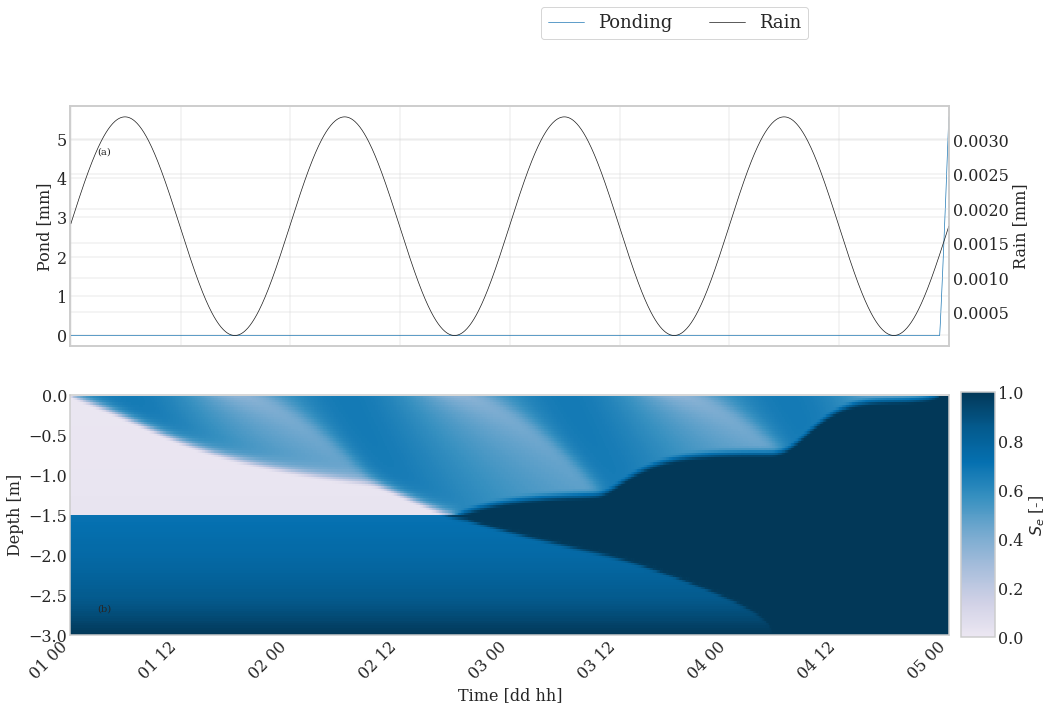

In [7]:
line_w = 0.7

start_date = '2022-01-01 00:00'
end_date = '2022-01-05 00:00'

plot_width = 40/2.54

fig, ax = plt.subplots(2, 1, sharex='col', gridspec_kw={'height_ratios': [1,1]},figsize=(plot_width,plot_width/1.618))

lns1 = ax[0].plot(ds.time.sel(time=slice(start_date, end_date)).values, ds.waterVolume.sel(depth=0).sel(time=slice(start_date,end_date))*1000, label='Ponding', color='#1f78b4', linewidth=line_w)

ax0twin = ax[0].twinx()
lns2 = ax0twin.plot(ds.time.sel(time=slice(start_date, end_date)).values, ds.topBC.sel(time=slice(start_date,end_date))/300, label='Rain', linewidth=line_w, color='0.1')

ax0twin.set_ylabel('Rain [mm]')
ax[0].set_ylabel('Pond [mm]')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, bbox_to_anchor=(0.85,1.45) , ncol=2)


norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
im = ds.saturationDegree.where(ds.depth<0.0).sel(time=slice(start_date, end_date)).plot(ax=ax[1], y='depth', add_colorbar=False, cmap=my_cmap, norm=norm)
ax[1].set_ylabel('Depth [m]')
ax[1].set_xlabel('Time [dd hh]')

cbaxes = fig.add_axes([0.91, 0.122, 0.03, 0.35]) 
cbar = fig.colorbar(im, ax=ax[1],orientation="vertical",fraction=0.07, pad=0.1, cax=cbaxes, label='$S_e$ [-]')

#ax[0].axvline(x=ds.time.sel(time='2022-01-01 10:35').values, linewidth=0.8, linestyle=(0, (1, 1)), color='red')
#ax[0].axvline(x=ds.time.sel(time='2022-01-01 17:00').values, linewidth=0.8, linestyle=(0, (1, 1)), color='red')

ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d %H'))
ax[1].xaxis.set_tick_params(rotation=45)

plt.text( 0.03,0.8, '(a)', fontsize=10,
             transform=ax[0].transAxes)
plt.text( 0.03,0.1, '(b)', fontsize=10,
             transform=ax[1].transAxes)


plt.show()

In [8]:
ds_bc = xr.open_dataset(project_path + '/output/E3_bc_out_0000.nc')
# ds

## MODELLO BROOKS COREY

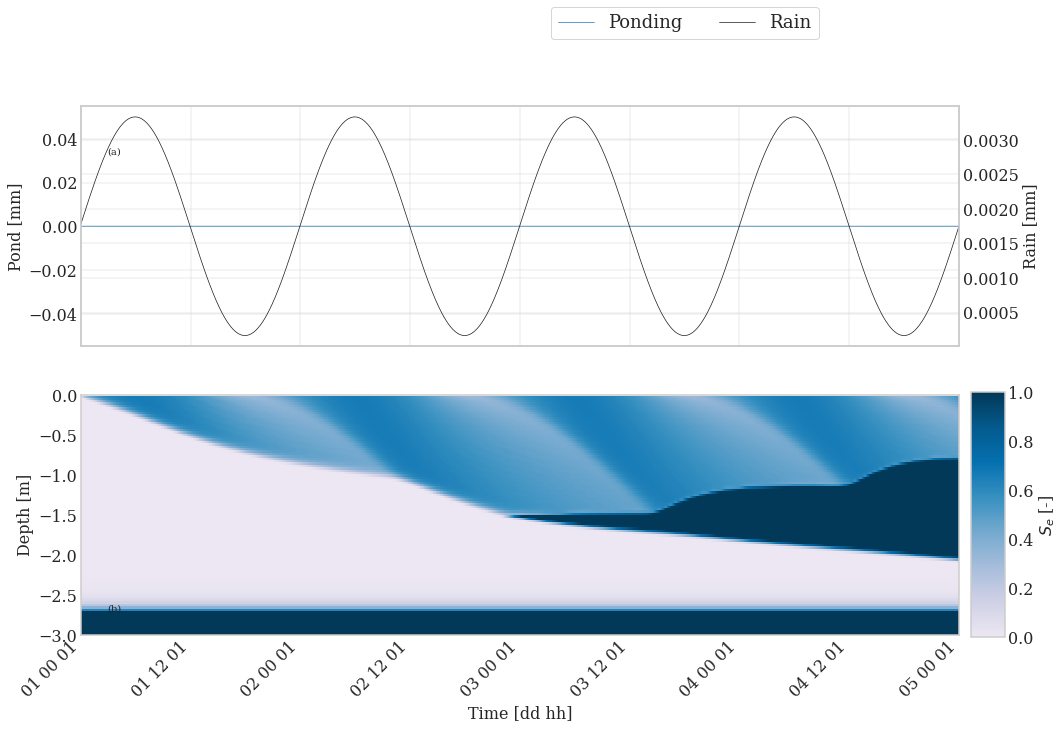

In [9]:
line_w = 0.7

start_date = '2022-01-01 00:00'
end_date = '2022-01-05 00:00'

plot_width = 40/2.54

fig, ax = plt.subplots(2, 1, sharex='col', gridspec_kw={'height_ratios': [1,1]},figsize=(plot_width,plot_width/1.618))

lns1 = ax[0].plot(ds_bc.time.sel(time=slice(start_date, end_date)).values, ds_bc.waterVolume.sel(depth=0).sel(time=slice(start_date,end_date))*1000,
                  label='Ponding', color='#1f78b4', linewidth=line_w)

ax0twin = ax[0].twinx()
lns2 = ax0twin.plot(ds_bc.time.sel(time=slice(start_date, end_date)).values, ds_bc.topBC.sel(time=slice(start_date,end_date))/300,
                    label='Rain', linewidth=line_w, color='0.1')

ax0twin.set_ylabel('Rain [mm]')
ax[0].set_ylabel('Pond [mm]')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, bbox_to_anchor=(0.85,1.45) , ncol=2)


norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
im = ds_bc.saturationDegree.where(ds_bc.depth<0.0).sel(time=slice(start_date, end_date)).plot(ax=ax[1], y='depth', add_colorbar=False,
                                                                                              cmap=my_cmap, norm=norm)
ax[1].set_ylabel('Depth [m]')
ax[1].set_xlabel('Time [dd hh]')

cbaxes = fig.add_axes([0.91, 0.122, 0.03, 0.35]) 
cbar = fig.colorbar(im, ax=ax[1],orientation="vertical",fraction=0.07, pad=0.1, cax=cbaxes, label='$S_e$ [-]')

#ax[0].axvline(x=ds_deep.time.sel(time='2020-01-01 10:35').values, linewidth=0.8, linestyle=(0, (1, 1)), color='red')
#ax[0].axvline(x=ds_deep.time.sel(time='2020-01-01 17:00').values, linewidth=0.8, linestyle=(0, (1, 1)), color='red')

ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d %H %m'))
ax[1].xaxis.set_tick_params(rotation=45)

plt.text( 0.03,0.8, '(a)', fontsize=10,
             transform=ax[0].transAxes)
plt.text( 0.03,0.1, '(b)', fontsize=10,
             transform=ax[1].transAxes)


plt.show()

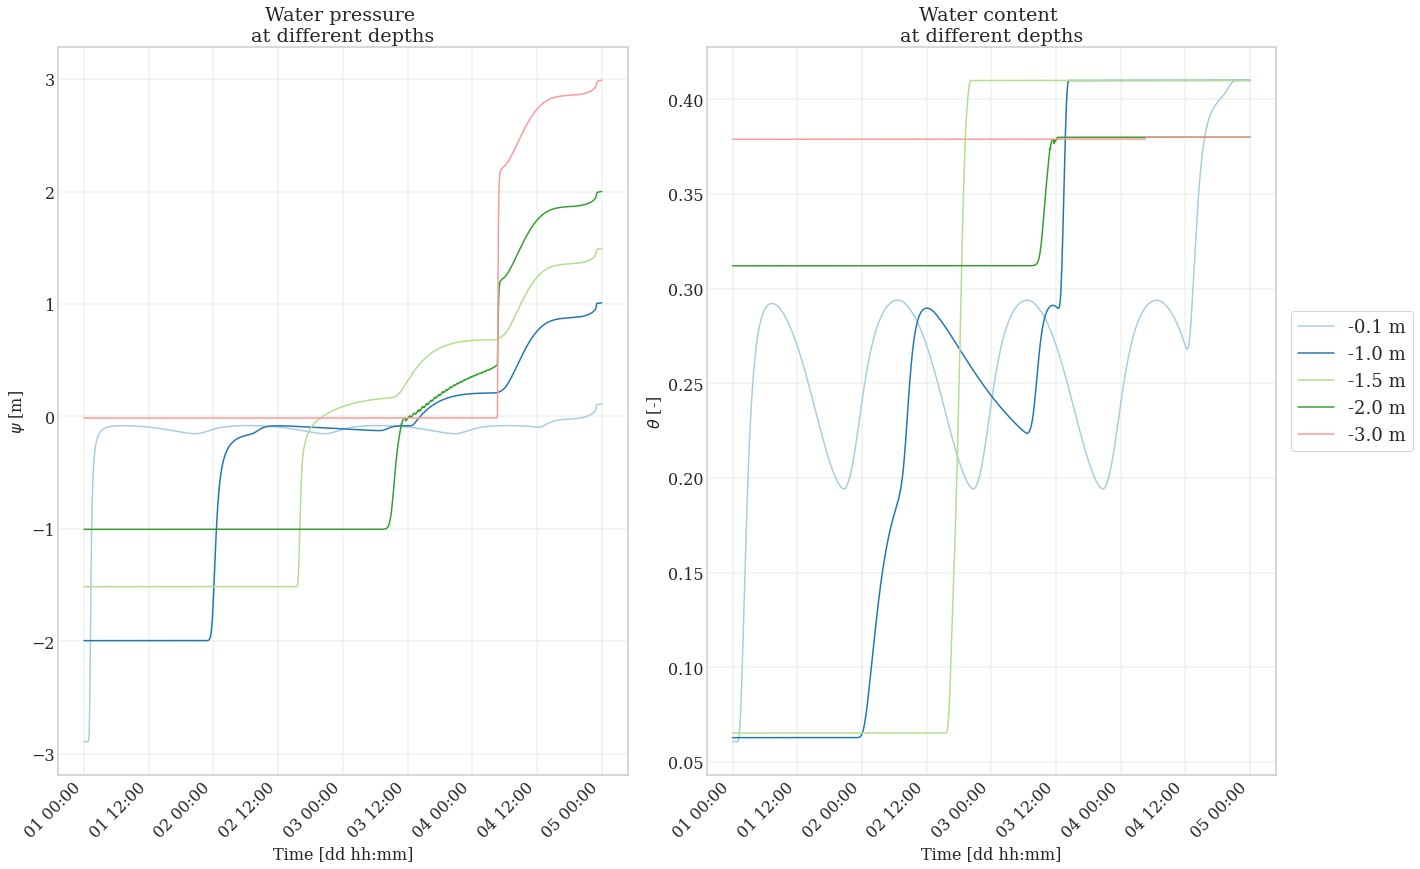

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20/1.618)) 

ds.psi.sel(depth=-0.1, method='nearest').plot(ax=ax1, color=colors[0])
ds.psi.sel(depth=-1.0, method='nearest').plot(ax=ax1, color=colors[1])
ds.psi.sel(depth=-1.5, method='nearest').plot(ax=ax1, color=colors[2])
ds.psi.sel(depth=-2.0, method='nearest').plot(ax=ax1, color=colors[3])
ds.psi.sel(depth=-3.0, method='nearest').plot(ax=ax1, color=colors[4])

ax1.set_title('Water pressure \nat different depths')

ax1.set_ylabel('$\psi$ [m]')
ax1.set_xlabel('Time [dd hh:mm]')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
ax1.xaxis.set_tick_params(rotation=45)

ds.theta.sel(depth=-0.1, method='nearest').plot(ax=ax2, label = '-0.1 m', color=colors[0])
ds.theta.sel(depth=-1.0, method='nearest').plot(ax=ax2, label = '-1.0 m', color=colors[1])
ds.theta.sel(depth=-1.5, method='nearest').plot(ax=ax2, label = '-1.5 m', color=colors[2])
ds.theta.sel(depth=-2.0, method='nearest').plot(ax=ax2, label = '-2.0 m', color=colors[3])
ds.theta.sel(depth=-3.0, method='nearest').plot(ax=ax2, label = '-3.0 m', color=colors[4])

ax2.set_title('Water content \nat different depths')

ax2.set_ylabel('$\\theta$ [-]')
ax2.set_xlabel('Time [dd hh:mm]')

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
ax2.xaxis.set_tick_params(rotation=45)

ax2.legend(bbox_to_anchor=(1.01,0.65), ncol=1)

plt.tight_layout()
plt.show()

## Flusso d'acqua attraverso il suolo
### Confronto fra superficie e fondo 

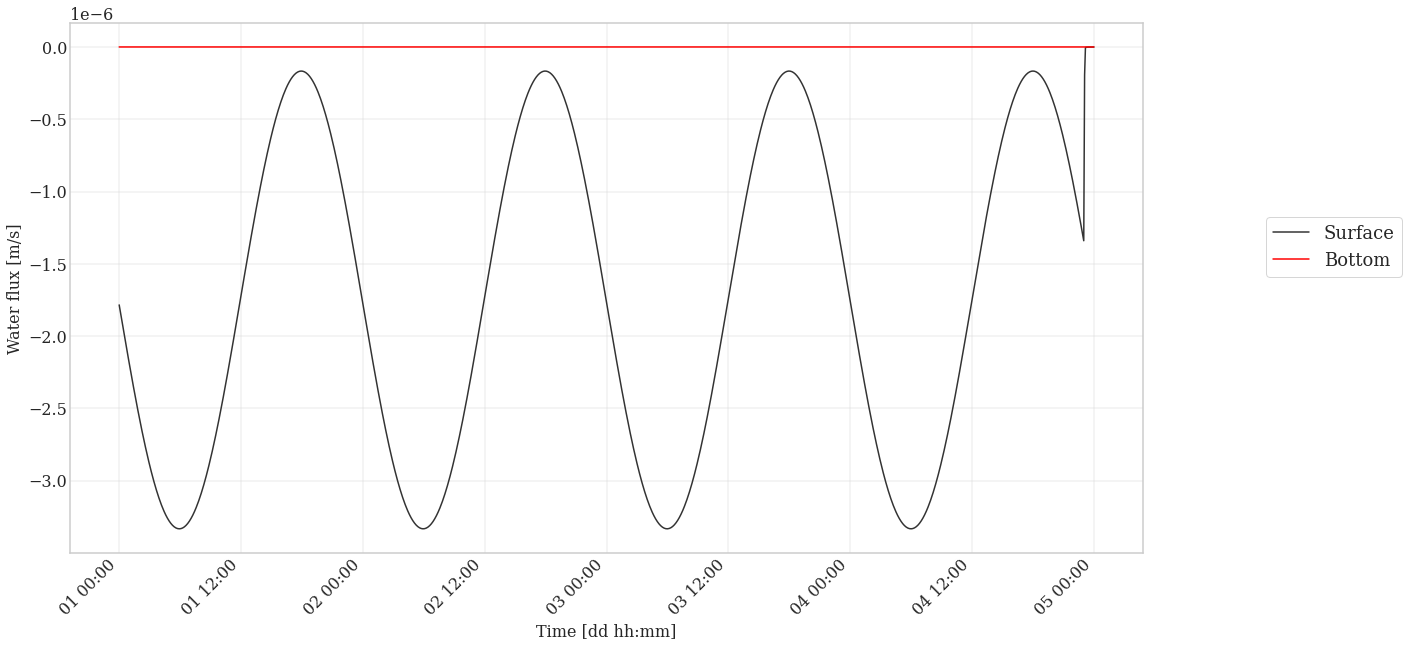

In [11]:
fig, ax= plt.subplots(1, 1, figsize=(20, 15/1.618)) 

ds.darcyVelocity.sel(dualDepth=0, method='nearest').plot(ax=ax, label='Surface', color='0.2')
ds.darcyVelocity.sel(dualDepth=-3.0, method='nearest').plot(ax=ax, label='Bottom', color='red')

ax.set_title('')

ax.set_ylabel('Water flux [m/s]')

ax.set_xlabel('Time [dd hh:mm]')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
ax.xaxis.set_tick_params(rotation=45)

ax.legend(bbox_to_anchor=(1.25,0.65), ncol=1)

plt.tight_layout()
plt.show()

## Flusso d'acqua cumulato attraverso la superficie e il fondo

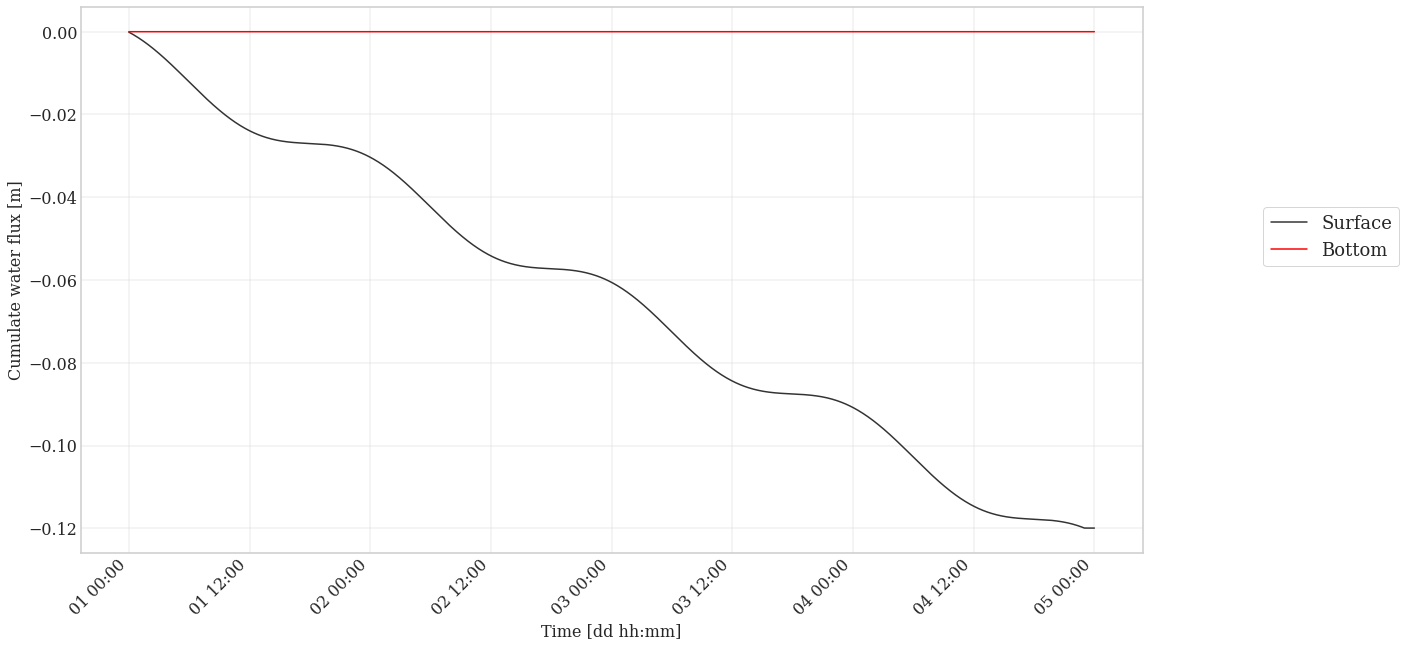

In [12]:
fig, ax= plt.subplots(1, 1, figsize=(20, 15/1.618)) 

(ds.darcyVelocity.sel(dualDepth=0, method='nearest')*60).cumsum().plot(ax=ax, label='Surface', color='0.2')
(ds.darcyVelocity.sel(dualDepth=-3.0, method='nearest')*60).cumsum().plot(ax=ax, label='Bottom', color='red')

ax.set_title('')

ax.set_ylabel('Cumulate water flux [m]')

ax.set_xlabel('Time [dd hh:mm]')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
ax.xaxis.set_tick_params(rotation=45)

ax.legend(bbox_to_anchor=(1.25,0.65), ncol=1)

plt.tight_layout()
plt.show()